<a href="https://colab.research.google.com/github/Harshnagwani123/CREDIT-CARD-FRAUD-DETECTION/blob/main/CREDIT_CARD_FRAUD_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# (optional) if using XGBoost
!pip -q install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("/content/creditcard.csv")
df.head(), df.shape, df['Class'].value_counts(normalize=True)


(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
         V26      

25 missing values total


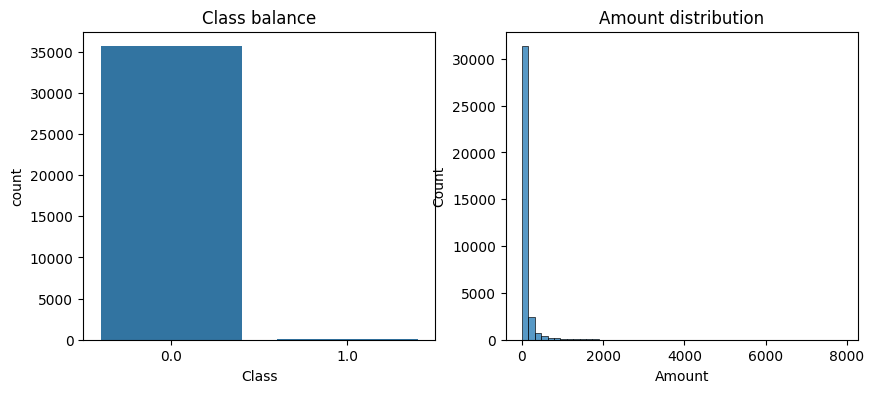

In [3]:
print(df.isna().sum().sum(), "missing values total")

fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='Class', data=df, ax=ax[0])
ax[0].set_title("Class balance")
sns.histplot(df['Amount'], bins=50, ax=ax[1]); ax[1].set_title("Amount distribution")
plt.show()


In [6]:
# Drop rows where 'Class' is NaN
df.dropna(subset=['Class'], inplace=True)

X = df.drop(columns=['Class'])
y = df['Class']

# Now convert 'Class' to int
y = df['Class'].astype(int)


num_to_scale = []
if 'Amount' in X.columns: num_to_scale.append('Amount')
if 'Time'   in X.columns: num_to_scale.append('Time')

pre = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), num_to_scale)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((28592, 30),
 (7149, 30),
 np.float64(0.002867935086737549),
 np.float64(0.0029374737725556023))

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_lr = Pipeline([
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Evaluate with CV using PR-AUC (average_precision), and also ROC-AUC
from sklearn.model_selection import cross_val_score
ap_scores  = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
roc_scores = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"LogReg CV PR-AUC:  {ap_scores.mean():.4f} ± {ap_scores.std():.4f}")
print(f"LogReg CV ROC-AUC: {roc_scores.mean():.4f} ± {roc_scores.std():.4f}")

# Fit on full train and evaluate on test
pipe_lr.fit(X_train, y_train)
proba_lr = pipe_lr.predict_proba(X_test)[:,1]
print("Test ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("Test PR-AUC: ", average_precision_score(y_test, proba_lr))


LogReg CV PR-AUC:  0.7207 ± 0.0332
LogReg CV ROC-AUC: 0.9780 ± 0.0249
Test ROC-AUC: 0.9526615359948692
Test PR-AUC:  0.44039681992197227


In [11]:
pipe_rf = Pipeline([
    ('pre', pre),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

param_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2, 5]
}

g_rf = GridSearchCV(
    pipe_rf, param_rf, cv=cv, scoring='average_precision',
    n_jobs=-1, verbose=0, refit=True
)
g_rf.fit(X_train, y_train)

print("RF best params:", g_rf.best_params_)
print("RF best CV PR-AUC:", g_rf.best_score_)

proba_rf = g_rf.predict_proba(X_test)[:,1]
print("RF Test ROC-AUC:", roc_auc_score(y_test, proba_rf))
print("RF Test PR-AUC: ", average_precision_score(y_test, proba_rf))


RF best params: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
RF best CV PR-AUC: 0.9322139593688812
RF Test ROC-AUC: 0.950490353268131
RF Test PR-AUC:  0.8512894947514436


In [12]:
pipe_ada = Pipeline([
    ('pre', pre),
    ('clf', AdaBoostClassifier(n_estimators=300, learning_rate=0.5, random_state=42))
])

ap_scores_ada = cross_val_score(pipe_ada, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
pipe_ada.fit(X_train, y_train)
proba_ada = pipe_ada.predict_proba(X_test)[:,1]

print(f"AdaBoost CV PR-AUC: {ap_scores_ada.mean():.4f}")
print("AdaBoost Test ROC-AUC:", roc_auc_score(y_test, proba_ada))
print("AdaBoost Test PR-AUC: ", average_precision_score(y_test, proba_ada))


AdaBoost CV PR-AUC: 0.9176
AdaBoost Test ROC-AUC: 0.969095719095719
AdaBoost Test PR-AUC:  0.8451811478288846


In [13]:
# scale_pos_weight ≈ (negatives / positives) in the training set
pos_ratio = (y_train == 1).sum() / (y_train == 0).sum()
spw = 1 / pos_ratio  # negatives/positives

pipe_xgb = Pipeline([
    ('pre', pre),
    ('clf', XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        scale_pos_weight=spw
    ))
])

ap_scores_xgb = cross_val_score(pipe_xgb, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
pipe_xgb.fit(X_train, y_train)
proba_xgb = pipe_xgb.predict_proba(X_test)[:,1]

print(f"XGBoost CV PR-AUC: {ap_scores_xgb.mean():.4f}")
print("XGBoost Test ROC-AUC:", roc_auc_score(y_test, proba_xgb))
print("XGBoost Test PR-AUC: ", average_precision_score(y_test, proba_xgb))


XGBoost CV PR-AUC: 0.9435
XGBoost Test ROC-AUC: 0.9949227727005505
XGBoost Test PR-AUC:  0.8903713649461927


In [14]:
comparison = pd.DataFrame({
    'Model': ['LogReg', 'RandomForest', 'AdaBoost', 'XGBoost'],
    'ROC_AUC': [
        roc_auc_score(y_test, proba_lr),
        roc_auc_score(y_test, proba_rf),
        roc_auc_score(y_test, proba_ada),
        roc_auc_score(y_test, proba_xgb),
    ],
    'PR_AUC': [
        average_precision_score(y_test, proba_lr),
        average_precision_score(y_test, proba_rf),
        average_precision_score(y_test, proba_ada),
        average_precision_score(y_test, proba_xgb),
    ],
})
comparison.sort_values('PR_AUC', ascending=False)


,Model,ROC_AUC,PR_AUC
3,XGBoost,0.994923,0.890371
1,RandomForest,0.950490,0.851289
2,AdaBoost,0.969096,0.845181
0,LogReg,0.952662,0.440397


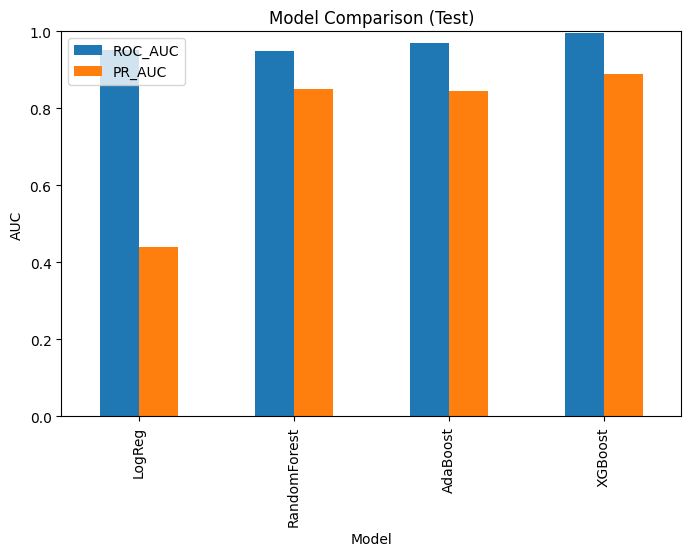

In [15]:
ax = comparison.set_index('Model')[['ROC_AUC','PR_AUC']].plot(kind='bar', figsize=(8,5))
ax.set_ylim(0,1); plt.title("Model Comparison (Test)"); plt.ylabel("AUC"); plt.show()


In [16]:
# choose the best proba vector (example: XGB)
proba_best = proba_xgb

prec, rec, thr = precision_recall_curve(y_test, proba_best)

# Option A: maximize F1
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_i = np.nanargmax(f1)
best_thr = thr[best_i - 1] if best_i > 0 else 0.5

best_thr


np.float32(0.777009)

In [17]:
# Evaluate at chosen threshold
y_pred_best = (proba_best >= best_thr).astype(int)
print("Threshold:", best_thr)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, digits=4))


Threshold: 0.777009
[[7127    1]
 [   3   18]]
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997      7128
           1     0.9474    0.8571    0.9000        21

    accuracy                         0.9994      7149
   macro avg     0.9735    0.9285    0.9499      7149
weighted avg     0.9994    0.9994    0.9994      7149



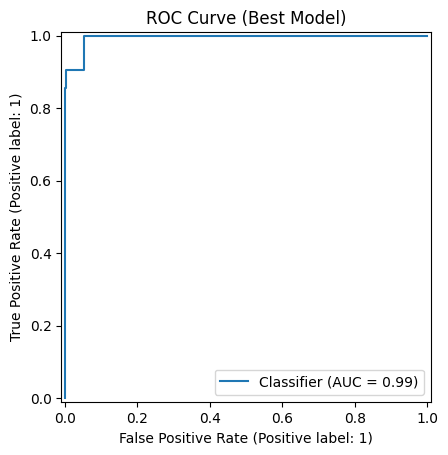

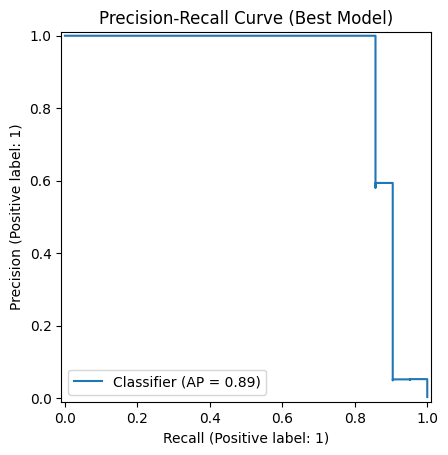

In [18]:
RocCurveDisplay.from_predictions(y_test, proba_best)
plt.title("ROC Curve (Best Model)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba_best)
plt.title("Precision-Recall Curve (Best Model)")
plt.show()
